# Hierarchical LDA Demo

This notebook demonstrates how we can load the BBC Insight Dataset (http://mlg.ucd.ie/datasets/bbc.html), preprocess them via NLTK and run hierarchical LDA inference on the data. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

import pylab as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from hlda.sampler import HierarchicalLDA

import string
import glob

## 1. Load test corpus

Load and preprocess text using NLTK. Below we load all tech articles from the BBC Insight corpus.

In [2]:
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said']

In [3]:
print stopset

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [4]:
corpus = []
all_docs = []
vocab = set()

stemmer = PorterStemmer()
for filename in glob.glob('../bbc/tech/*.txt'):
    with open(filename) as f:
        try:
            
            doc = f.read().splitlines() 
            doc = filter(None, doc) # remove empty string
            doc = '. '.join(doc)
            doc = doc.translate(None, string.punctuation) # strip punctuations
            doc = doc.translate(None, '0123456789') # strip numbers        
            doc = doc.decode("utf8").encode('ascii', 'ignore') # ignore all fancy unicode characters
            all_docs.append(doc)        

            tokens = word_tokenize(str(doc))
            filtered = []
            for w in tokens:
                w = stemmer.stem(w.lower()) # use Porter's stemmer
                if len(w) < 3:              # remove short tokens
                    continue
                if w in stopset:            # remove stop words
                    continue
                filtered.append(w)
                
            vocab.update(filtered)
            corpus.append(filtered)      
            
        except UnicodeDecodeError:
            print 'Failed to load', filename

Create an inverted index for the words to position in the sorted vocab

In [5]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i

Total number of documents in the corpus

In [6]:
print len(all_docs)

401


Total number of vocab. Also print the first 500 words in the sorted vocab.

In [7]:
print len(vocab)
print vocab[0:100]

8185
[u'aaa', 'aac', 'aadc', u'aarhu', 'aaron', u'abacu', u'abandon', u'abat', 'abbott', 'abensur', u'abet', u'abid', u'abil', u'abl', u'ablebodi', u'aboutroughli', u'abov', u'aboveaverag', 'abraham', u'abramovich', 'abroad', u'abruptli', u'absenc', u'absolut', u'absorb', 'abstain', 'abstract', 'abtahi', u'abund', u'abundantli', u'abus', u'academ', u'academi', 'academia', u'acceler', 'accept', u'access', u'accessori', u'accid', u'accident', 'acclaim', u'acclim', u'accolad', u'accommod', u'accompani', u'accomplic', u'accomplish', u'accord', u'accordingli', 'account', u'accumul', u'accur', u'accuraci', u'accus', u'achiev', 'acid', u'acknowledg', u'acquiesc', u'acquir', u'acquisit', u'acquit', u'acr', u'acrobat', u'across', 'act', 'action', 'actionfest', u'actionpack', u'activ', 'activcard', u'actor', 'actual', u'acut', 'adam', 'adamind', u'adapt', 'adaptor', u'adawar', u'add', u'addict', 'addin', u'addit', u'addon', u'address', 'adept', u'adequ', u'adher', u'adict', u'adida', u'adjudg', 

## 2. Visualise the data

Make some pretty word cloud using the Python Word Cloud package: https://github.com/amueller/word_cloud

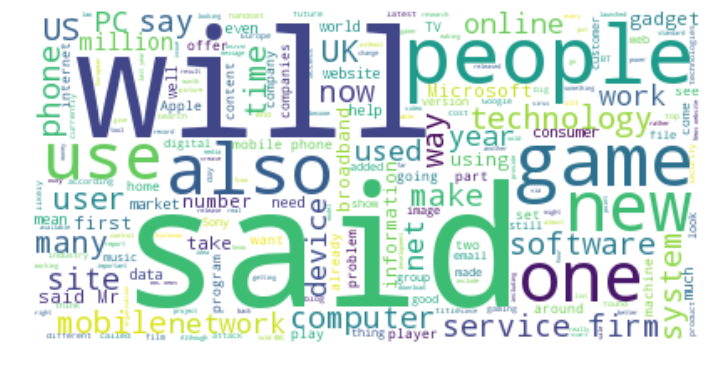

In [8]:
wordcloud = WordCloud(background_color='white').generate(' '.join(all_docs))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Run hLDA

In [9]:
print len(vocab), len(corpus), len(corpus[0]), len(corpus[1])

8185 401 378 210


Convert words in the corpus into indices

In [10]:
new_corpus = []
for doc in corpus:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [11]:
print len(vocab), len(new_corpus)
print corpus[0][0:100]
print new_corpus[0][0:100]

8185 401
['ink', u'help', 'drive', u'democraci', 'asia', 'kyrgyz', u'republ', 'small', u'mountain', 'state', 'former', 'soviet', u'republ', u'use', u'invis', 'ink', 'ultraviolet', u'reader', u'countri', u'elect', 'part', 'drive', 'prevent', u'multipl', u'vote', u'thi', 'new', u'technolog', u'caus', u'worri', u'guard', u'optim', 'among', u'differ', u'sector', u'popul', 'effort', 'live', u'reput', 'island', u'democraci', 'kyrgyz', u'presid', 'askar', 'akaev', u'push', 'law', u'requir', 'use', 'ink', u'dure', u'upcom', u'parliamentari', u'presidenti', u'elect', u'govern', u'agre', 'fund', u'expens', u'associ', u'thi', u'decis', 'kyrgyz', u'republ', 'seen', u'mani', u'expert', u'backslid', 'high', 'point', u'reach', u'mid', u'hastili', u'push', 'referendum', u'reduc', u'legisl', 'branch', 'one', 'chamber', u'deputi', 'use', 'ink', u'onli', 'one', 'part', u'gener', 'effort', 'show', u'commit', u'toward', 'open', u'elect', 'german', u'embassi', u'soro', u'foundat', 'kyrgyz', u'govern', u'con

Create hierarchical LDA object and run the sampler.

In [12]:
n_samples = 500       # no of iterations for the sampler
alpha = 10.0          # smoothing over level distributions
gamma = 1.0           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.1             # smoothing over topic-word distributions
num_levels = 3        # the number of levels in the tree
display_topics = 50   # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights

In [13]:
hlda = HierarchicalLDA(new_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

HierarchicalLDA sampling
.................................................. 50
topic 0 (level=0, total_words=46467, documents=401): peopl, use, thi, one, get, 
    topic 1 (level=1, total_words=4156, documents=87): game, player, soni, devic, digit, 
        topic 2 (level=2, total_words=2130, documents=33): music, domain, cell, chip, gadget, 
        topic 11 (level=2, total_words=1052, documents=9): robot, world, human, tour, lift, 
        topic 12 (level=2, total_words=2664, documents=24): broadband, attack, speed, network, data, 
        topic 17 (level=2, total_words=1242, documents=11): radio, hiphop, music, program, millan, 
        topic 21 (level=2, total_words=914, documents=10): sport, reddi, farmer, virtual, hunt, 
    topic 3 (level=1, total_words=8121, documents=128): phone, digit, mobil, devic, market, 
        topic 4 (level=2, total_words=4976, documents=61): mobil, servic, content, broadcast, broadband, 
        topic 9 (level=2, total_words=4698, documents=48): email